In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statistics import mode 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['Data_Dictionary.xlsx', 'new_merchant_transactions.csv', 'test.csv', 'merchants.csv', 'historical_transactions.csv', 'all.zip', 'train.csv', 'sample_submission.csv']


In [32]:
train_df = pd.read_csv("./input/train.csv")
test_df = pd.read_csv("./input/test.csv")
# merchants_df = pd.read_csv("./input/merchants.csv")
# new_merchant_transactions_df = pd.read_csv("./input/new_merchant_transactions.csv", )
# historical_transactions_df = pd.read_csv("./input/historical_transactions.csv")

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
historical_transactions_df = reduce_mem_usage(historical_transactions_df)
new_merchant_transactions_df = reduce_mem_usage(new_merchant_transactions_df)
merchants_df = reduce_mem_usage(merchants_df)

Memory usage of dataframe is 3109.54 MB
Memory usage after optimization is: 1622.97 MB
Decreased by 47.8%
Memory usage of dataframe is 209.67 MB
Memory usage after optimization is: 169.08 MB
Decreased by 19.4%
Memory usage of dataframe is 56.18 MB
Memory usage after optimization is: 32.66 MB
Decreased by 41.9%


In [5]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [6]:
train_df.shape

(201917, 6)

In [6]:
test_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [7]:
test_df.shape

(123623, 5)

In [9]:
merchants_df.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.400000,...,-2.250000,18.666667,6,-2.320000,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720000,...,-0.740000,1.291667,6,-0.570000,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.129997,...,-82.129997,260.000000,2,-82.129997,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057465,-0.057465,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057465,-0.057465,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [10]:
merchants_df.shape

(334696, 22)

In [11]:
new_merchant_transactions_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,NaN,-1,29


In [12]:
historical_transactions_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [13]:
historical_transactions_df.isna().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

In [8]:
historical_transactions_df['category_3'].value_counts()

A    15411747
B    11677522
C     1844933
Name: category_3, dtype: int64

In [15]:
new_merchant_transactions_df.isna().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

In [16]:
new_merchant_transactions_df['category_3'].value_counts()

A    922244
B    836178
C    148687
Name: category_3, dtype: int64

In [17]:
new_merchant_transactions_df.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19


In [7]:
new_merchant_transactions_df['category_2'].fillna(1.0, inplace=True)
new_merchant_transactions_df['category_3'].fillna('A', inplace=True)

historical_transactions_df['category_2'].fillna(1.0, inplace=True)
historical_transactions_df['category_3'].fillna('A', inplace=True)

In [19]:
#del historical_transactions_df['category_2']
#del historical_transactions_df['category_3']

#del new_merchant_transactions_df['category_2']
#del new_merchant_transactions_df['category_3']

In [8]:
historical_transactions_df = historical_transactions_df.dropna()
new_merchant_transactions_df = new_merchant_transactions_df.dropna()

In [21]:
train_df.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913


In [22]:
test_df.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0


In [35]:
train_df['first_active_month'] = pd.to_datetime(train_df['first_active_month'])
test_df['first_active_month'] = pd.to_datetime(test_df['first_active_month'])

In [34]:
train_df.dtypes

first_active_month    datetime64[ns]
card_id                       object
feature_1                      int64
feature_2                      int64
feature_3                      int64
target                       float64
dtype: object

In [25]:
#hist_trans_df_group = historical_transactions_df.groupby('card_id')

In [26]:
historical_transactions_df.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16


In [27]:
new_merchant_transactions_df.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19


In [9]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions_df = binarize(historical_transactions_df)
new_merchant_transactions_df = binarize(new_merchant_transactions_df)

In [10]:
historical_transactions_df['category_3'] = historical_transactions_df['category_3'].astype('category').cat.codes
new_merchant_transactions_df['category_3'] = new_merchant_transactions_df['category_3'].astype('category').cat.codes

In [11]:
historical_transactions_df.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16


In [12]:
new_merchant_transactions_df.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,0,1,1,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,0,1,1,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19


In [13]:
transactions = historical_transactions_df.append(new_merchant_transactions_df)

In [33]:
historical_transactions_df.shape

(28973880, 14)

In [34]:
new_merchant_transactions_df.shape

(1936815, 14)

In [35]:
transactions.shape

(30910695, 14)

In [14]:
del historical_transactions_df
del new_merchant_transactions_df

In [15]:
from scipy import stats

In [16]:
def aggregate_transactions(history):
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    agg_func = {
        'authorized_flag': ['sum', 'mean', lambda x: tuple(stats.mode(x)[0])],
        'category_1': ['sum', 'mean', lambda x: tuple(stats.mode(x)[0])],
        'category_2': ['sum', 'mean', lambda x: tuple(stats.mode(x)[0])],
        'category_3': ['sum', 'mean', lambda x: tuple(stats.mode(x)[0])],
        'merchant_id': ['nunique', lambda x: tuple(stats.mode(x)[0])],
        'merchant_category_id': ['nunique', lambda x: tuple(stats.mode(x)[0])],
        'state_id': ['nunique', lambda x: tuple(stats.mode(x)[0])],
        'city_id': ['nunique', lambda x: tuple(stats.mode(x)[0])],
        'subsector_id': ['nunique', lambda x: tuple(stats.mode(x)[0])],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'month_lag': [ lambda x: tuple(stats.mode(x)[0])]
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [17]:
history = aggregate_transactions(transactions)

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [18]:
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_merchant_id_nunique,hist_merchant_id_<lambda>,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_state_id_nunique,...,hist_category_3_sum,hist_category_3_mean,hist_category_3_<lambda>,hist_month_lag_<lambda>,hist_category_2_sum,hist_category_2_mean,hist_category_2_<lambda>,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_<lambda>
0,C_ID_00007093c1,151,31,"(M_ID_9400cf2342,)",-78.173653,-0.517706,1.507069,-0.728876,0.296638,4,...,175.0,1.158940,"(1,)","(-8,)",397.0,2.628906,"(3.0,)",116,0.768212,"(1,)"
1,C_ID_0001238066,148,90,"(M_ID_d17aabd756,)",-86.597160,-0.585116,0.768095,-0.740723,0.187366,6,...,180.0,1.216216,"(1,)","(-2,)",240.0,1.622070,"(1.0,)",145,0.979730,"(1,)"
2,C_ID_0001506ef0,67,29,"(M_ID_b1fc88154d,)",-35.333813,-0.527370,1.493545,-0.740491,0.469379,2,...,1.0,0.014925,"(0,)","(-2,)",197.0,2.939453,"(3.0,)",63,0.940299,"(1,)"
3,C_ID_0001793786,247,150,"(M_ID_923d57de8d,)",-37.015015,-0.149858,4.554145,-0.745405,0.850442,5,...,5.0,0.020243,"(0,)","(-1,)",375.0,1.518555,"(1.0,)",220,0.890688,"(1,)"
4,C_ID_000183fdda,155,84,"(M_ID_f9cfe0a43b,)",-75.428757,-0.486637,2.764788,-0.737892,0.508951,7,...,191.0,1.232258,"(1,)","(-1,)",444.0,2.865234,"(3.0,)",148,0.954839,"(1,)"


In [ ]:
history.shape

In [ ]:
history.head(2)

In [36]:
train = pd.merge(train_df, history, on ='card_id', how='left')
test = pd.merge(test_df, history, on ='card_id', how='left')

In [37]:
train['hist_authorized_flag_<lambda>'] = train['hist_authorized_flag_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)
train['hist_category_1_<lambda>'] = train['hist_category_1_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)

In [38]:
train['hist_category_2_<lambda>'] = train['hist_category_2_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
train['hist_category_3_<lambda>'] = train['hist_category_3_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
train['hist_merchant_id_<lambda>'] = train['hist_merchant_id_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
train['hist_merchant_category_id_<lambda>'] = train['hist_merchant_category_id_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)
train['hist_state_id_<lambda>'] = train['hist_state_id_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)
train['hist_city_id_<lambda>'] = train['hist_city_id_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)
train['hist_subsector_id_<lambda>'] = train['hist_subsector_id_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)
train['hist_month_lag_<lambda>'] = train['hist_month_lag_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)

In [39]:
test['hist_authorized_flag_<lambda>'] = test['hist_authorized_flag_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)
test['hist_category_1_<lambda>'] = test['hist_category_1_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)
test['hist_category_2_<lambda>'] = test['hist_category_2_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
test['hist_category_3_<lambda>'] = test['hist_category_3_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)'))

test['hist_merchant_id_<lambda>'] = test['hist_merchant_id_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
test['hist_merchant_category_id_<lambda>'] = test['hist_merchant_category_id_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)
test['hist_state_id_<lambda>'] = test['hist_state_id_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)
test['hist_city_id_<lambda>'] = test['hist_city_id_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)
test['hist_subsector_id_<lambda>'] = test['hist_subsector_id_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)
test['hist_month_lag_<lambda>'] = test['hist_month_lag_<lambda>'].map(lambda x: str(x).lstrip('(').rstrip(',)')).astype(int)

In [40]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_merchant_id_nunique,hist_merchant_id_<lambda>,hist_purchase_amount_sum,hist_purchase_amount_mean,...,hist_category_3_sum,hist_category_3_mean,hist_category_3_<lambda>,hist_month_lag_<lambda>,hist_category_2_sum,hist_category_2_mean,hist_category_2_<lambda>,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_<lambda>
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,71,27,'M_ID_9139332ccc',-42.511078,-0.598748,...,94.0,1.323944,1,-6,71.0,1.000000,1.0,47,0.661972,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,87,36,'M_ID_7e6e285f13',-55.080849,-0.633113,...,90.0,1.034483,1,-10,335.0,3.849609,4.0,86,0.988506,1
2,2017-08-01,C_ID_b709037bc5,5,1,1,15,11,'M_ID_c708cbb89a',4.708528,0.313902,...,22.0,1.466667,2,-3,63.0,4.199219,5.0,11,0.733333,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0,36,33,'M_ID_44485d60c0',-19.435101,-0.539864,...,46.0,1.277778,1,-2,40.0,1.111328,1.0,36,1.000000,1
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,116,53,'M_ID_d895cb84ae',37.205791,0.320740,...,122.0,1.051724,1,0,446.0,3.845703,4.0,93,0.801724,1


In [41]:
test.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'hist_transactions_count', 'hist_merchant_id_nunique',
       'hist_merchant_id_<lambda>', 'hist_purchase_amount_sum',
       'hist_purchase_amount_mean', 'hist_purchase_amount_max',
       'hist_purchase_amount_min', 'hist_purchase_amount_std',
       'hist_state_id_nunique', 'hist_state_id_<lambda>',
       'hist_installments_sum', 'hist_installments_mean',
       'hist_installments_max', 'hist_installments_min',
       'hist_installments_std', 'hist_subsector_id_nunique',
       'hist_subsector_id_<lambda>', 'hist_category_1_sum',
       'hist_category_1_mean', 'hist_category_1_<lambda>',
       'hist_city_id_nunique', 'hist_city_id_<lambda>',
       'hist_merchant_category_id_nunique',
       'hist_merchant_category_id_<lambda>', 'hist_category_3_sum',
       'hist_category_3_mean', 'hist_category_3_<lambda>',
       'hist_month_lag_<lambda>', 'hist_category_2_sum',
       'hist_category_2_mean', 

In [25]:
 test.columns = ['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'hist_transactions_count', 'hist_authorized_flag_sum',
       'hist_authorized_flag_mean', 'hist_authorized_flag_mode',
       'hist_category_1_sum', 'hist_category_1_mean',
       'hist_category_1_mode', 'hist_category_2_sum',
       'hist_category_2_mean', 'hist_category_2_mode',
       'hist_category_3_sum', 'hist_category_3_mean',
       'hist_category_3_mode', 'hist_merchant_id_nunique',
       'hist_merchant_id_mode', 'hist_merchant_category_id_nunique',
       'hist_merchant_category_id_mode', 'hist_state_id_nunique',
       'hist_state_id_mode', 'hist_city_id_nunique',
       'hist_city_id_mode', 'hist_subsector_id_nunique',
       'hist_subsector_id_mode', 'hist_purchase_amount_sum',
       'hist_purchase_amount_mean', 'hist_purchase_amount_max',
       'hist_purchase_amount_min', 'hist_purchase_amount_std',
       'hist_installments_sum', 'hist_installments_mean',
       'hist_installments_max', 'hist_installments_min',
       'hist_installments_std', 'hist_month_lag_mode']

In [42]:
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'hist_transactions_count', 'hist_merchant_id_nunique',
       'hist_merchant_id_<lambda>', 'hist_purchase_amount_sum',
       'hist_purchase_amount_mean', 'hist_purchase_amount_max',
       'hist_purchase_amount_min', 'hist_purchase_amount_std',
       'hist_state_id_nunique', 'hist_state_id_<lambda>',
       'hist_installments_sum', 'hist_installments_mean',
       'hist_installments_max', 'hist_installments_min',
       'hist_installments_std', 'hist_subsector_id_nunique',
       'hist_subsector_id_<lambda>', 'hist_category_1_sum',
       'hist_category_1_mean', 'hist_category_1_<lambda>',
       'hist_city_id_nunique', 'hist_city_id_<lambda>',
       'hist_merchant_category_id_nunique',
       'hist_merchant_category_id_<lambda>', 'hist_category_3_sum',
       'hist_category_3_mean', 'hist_category_3_<lambda>',
       'hist_month_lag_<lambda>', 'hist_category_2_sum',
       'hist_category

In [28]:
train.columns = ['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'hist_transactions_count', 'hist_authorized_flag_sum',
       'hist_authorized_flag_mean', 'hist_authorized_flag_mode',
       'hist_category_1_sum', 'hist_category_1_mean',
       'hist_category_1_mode', 'hist_category_2_sum',
       'hist_category_2_mean', 'hist_category_2_mode',
       'hist_category_3_sum', 'hist_category_3_mean',
       'hist_category_3_mode', 'hist_merchant_id_nunique',
       'hist_merchant_id_mode', 'hist_merchant_category_id_nunique',
       'hist_merchant_category_id_<lambda>', 'hist_state_id_nunique',
       'hist_state_id_mode', 'hist_city_id_nunique',
       'hist_city_id_mode', 'hist_subsector_id_nunique',
       'hist_subsector_id_mode', 'hist_purchase_amount_sum',
       'hist_purchase_amount_mean', 'hist_purchase_amount_max',
       'hist_purchase_amount_min', 'hist_purchase_amount_std',
       'hist_installments_sum', 'hist_installments_mean',
       'hist_installments_max', 'hist_installments_min',
       'hist_installments_std', 'hist_month_lag_mode']

In [30]:
test.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_mode,hist_category_1_sum,...,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_month_lag_mode
0,2017-04,C_ID_0ab67a22ab,3,3,1,71,27,'M_ID_9139332ccc',-42.511078,-0.598748,...,94.0,1.323944,1,-6,71.0,1.000000,1.0,47,0.661972,1
1,2017-01,C_ID_130fd0cbdd,2,3,0,87,36,'M_ID_7e6e285f13',-55.080849,-0.633113,...,90.0,1.034483,1,-10,335.0,3.849609,4.0,86,0.988506,1


In [130]:
# del transactions

In [131]:
merchants_df.isna().sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

In [132]:
merchants_df['category_2'].value_counts()

1.0    160888
5.0     52923
3.0     51887
4.0     36450
2.0     20661
Name: category_2, dtype: int64

In [60]:
#merchants_df['avg_sales_lag6'].value_counts()

In [44]:
###### merchants_df['avg_sales_lag3'].fillna(1.0, inplace = True)
merchants_df['avg_sales_lag3'].fillna(1.0, inplace = True)
merchants_df['avg_sales_lag6'].fillna(1.0, inplace = True)
merchants_df['avg_sales_lag12'].fillna(1.0, inplace = True)

In [45]:
merchants_df['category_2'].fillna(1.0, inplace = True)

In [46]:
merchants_df.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.400000,...,-2.250000,18.666667,6,-2.320000,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720000,...,-0.740000,1.291667,6,-0.570000,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.129997,...,-82.129997,260.000000,2,-82.129997,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057465,-0.057465,Y,E,E,1.000000,...,1.000000,4.666667,6,1.000000,3.833333,12,Y,-1,-1,1.0
4,M_ID_64456c37ce,2228,222,21,-0.057465,-0.057465,Y,E,E,1.000000,...,1.000000,0.361111,6,1.000000,0.347222,12,Y,-1,-1,1.0


In [47]:
merchants_df['category_4'].value_counts()

N    238596
Y     96100
Name: category_4, dtype: int64

In [48]:
merchants_df['category_1'] = merchants_df['category_1'].astype('category').cat.codes
merchants_df['most_recent_sales_range'] = merchants_df['most_recent_sales_range'].astype('category').cat.codes

merchants_df['most_recent_purchases_range'] = merchants_df['most_recent_purchases_range'].astype('category').cat.codes
merchants_df['category_4'] = merchants_df['category_4'].astype('category').cat.codes

In [66]:
merchants_df.apply(lambda x:len(x.unique()))

merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
numerical_1                       950
numerical_2                       944
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
avg_sales_lag3                   3372
avg_purchases_lag3             100003
active_months_lag3                  3
avg_sales_lag6                   4507
avg_purchases_lag6             135202
active_months_lag6                  6
avg_sales_lag12                  5009
avg_purchases_lag12            172917
active_months_lag12                12
category_4                          2
city_id                           271
state_id                           25
category_2                          5
dtype: int64

In [67]:
merchants_df.columns

Index(['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2'],
      dtype='object')

In [68]:
merchants_df.apply(lambda x:len(x.unique()))

merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
numerical_1                       950
numerical_2                       944
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
avg_sales_lag3                   3372
avg_purchases_lag3             100003
active_months_lag3                  3
avg_sales_lag6                   4507
avg_purchases_lag6             135202
active_months_lag6                  6
avg_sales_lag12                  5009
avg_purchases_lag12            172917
active_months_lag12                12
category_4                          2
city_id                           271
state_id                           25
category_2                          5
dtype: int64

In [49]:
def aggregate_merchants(history):
    
    agg_func = {
    
        'merchant_group_id': [lambda x: tuple(stats.mode(x)[0])],
        'merchant_category_id': [lambda x: tuple(stats.mode(x)[0])],
        'subsector_id': [lambda x: tuple(stats.mode(x)[0])],
        'numerical_1': ['sum', 'mean'],
        'numerical_2': ['sum', 'mean'],
        'category_1': [lambda x: tuple(stats.mode(x)[0])],
        'most_recent_sales_range': [lambda x: tuple(stats.mode(x)[0])],
        'most_recent_purchases_range': [lambda x: tuple(stats.mode(x)[0])],
        'avg_sales_lag3': ['sum', 'mean'],
        'avg_purchases_lag3': ['sum', 'mean'],
        'active_months_lag3': [lambda x: tuple(stats.mode(x)[0])],
        'avg_sales_lag6': ['mean',lambda x: tuple(stats.mode(x)[0])],
        'avg_purchases_lag6': ['sum', 'mean'],
        'active_months_lag6': [lambda x: tuple(stats.mode(x)[0])],
        'avg_sales_lag12': ['sum', 'mean'],
        'avg_purchases_lag12': ['sum', 'mean'],
        'active_months_lag12': [lambda x: tuple(stats.mode(x)[0])],
        'category_4': [lambda x: tuple(stats.mode(x)[0])],
        'city_id': [lambda x: tuple(stats.mode(x)[0])],
        'state_id': [lambda x: tuple(stats.mode(x)[0])],
        'category_2': [lambda x: tuple(stats.mode(x)[0])]
        
    }
    
    agg_history = history.groupby(['merchant_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('merchant_id')
          .size()
          .reset_index(name='merchant_count'))
    
    agg_history = pd.merge(df, agg_history, on='merchant_id', how='left')
    
    return agg_history

In [50]:
merchants_data = aggregate_merchants(merchants_df)

In [51]:
merchants_data.columns = ['merch_' + c if c != 'merchant_id' else c for c in merchants_data.columns]
merchants_data[:5]

,merchant_id,merch_merchant_count,merch_category_4_<lambda>,merch_numerical_2_sum,merch_numerical_2_mean,merch_state_id_<lambda>,merch_most_recent_purchases_range_<lambda>,merch_active_months_lag6_<lambda>,merch_subsector_id_<lambda>,merch_avg_sales_lag3_sum,...,merch_numerical_1_mean,merch_avg_purchases_lag6_sum,merch_avg_purchases_lag6_mean,merch_category_2_<lambda>,merch_avg_sales_lag12_sum,merch_avg_sales_lag12_mean,merch_active_months_lag3_<lambda>,merch_active_months_lag12_<lambda>,merch_avg_purchases_lag3_sum,merch_avg_purchases_lag3_mean
0,M_ID_000025127f,1,"(1,)",-0.057465,-0.057465,"(9,)","(4,)","(6,)","(37,)",1.29,...,-0.057465,2.228632,2.228632,"(1.0,)",1.08,1.08,"(3,)","(12,)",1.880342,1.880342
1,M_ID_0000699140,1,"(0,)",-0.057465,-0.057465,"(9,)","(3,)","(6,)","(27,)",0.99,...,-0.057465,1.002168,1.002168,"(1.0,)",1.24,1.24,"(3,)","(12,)",0.997832,0.997832
2,M_ID_00006a5552,1,"(0,)",-0.057465,-0.057465,"(15,)","(4,)","(6,)","(29,)",1.21,...,-0.057465,1.000000,1.000000,"(1.0,)",1.22,1.22,"(3,)","(12,)",1.000000,1.000000
3,M_ID_000087311e,1,"(1,)",-0.057465,-0.057465,"(-1,)","(4,)","(6,)","(1,)",0.93,...,-0.057465,1.300926,1.300926,"(1.0,)",0.78,0.78,"(3,)","(12,)",1.314815,1.314815
4,M_ID_0000ab0b2d,1,"(0,)",-0.057465,-0.057465,"(9,)","(3,)","(6,)","(16,)",1.05,...,-0.057465,1.057279,1.057279,"(1.0,)",1.06,1.06,"(3,)","(12,)",1.089897,1.089897


In [52]:
merchants_data.shape

(334633, 31)

In [53]:
merchants_data.columns

Index(['merchant_id', 'merch_merchant_count', 'merch_category_4_<lambda>',
       'merch_numerical_2_sum', 'merch_numerical_2_mean',
       'merch_state_id_<lambda>', 'merch_most_recent_purchases_range_<lambda>',
       'merch_active_months_lag6_<lambda>', 'merch_subsector_id_<lambda>',
       'merch_avg_sales_lag3_sum', 'merch_avg_sales_lag3_mean',
       'merch_merchant_group_id_<lambda>', 'merch_category_1_<lambda>',
       'merch_avg_sales_lag6_mean', 'merch_avg_sales_lag6_<lambda>',
       'merch_avg_purchases_lag12_sum', 'merch_avg_purchases_lag12_mean',
       'merch_city_id_<lambda>', 'merch_merchant_category_id_<lambda>',
       'merch_most_recent_sales_range_<lambda>', 'merch_numerical_1_sum',
       'merch_numerical_1_mean', 'merch_avg_purchases_lag6_sum',
       'merch_avg_purchases_lag6_mean', 'merch_category_2_<lambda>',
       'merch_avg_sales_lag12_sum', 'merch_avg_sales_lag12_mean',
       'merch_active_months_lag3_<lambda>',
       'merch_active_months_lag12_<lambda>'

In [134]:
merchants_data.columns = ['merchant_id', 'merch_merchant_count',
       'merch_merchant_group_id_mode',
       'merch_merchant_category_id_mode', 'merch_subsector_id_mode',
       'merch_numerical_1_sum', 'merch_numerical_1_mean',
       'merch_numerical_2_sum', 'merch_numerical_2_mean',
       'merch_category_1_mode', 'merch_most_recent_sales_range_mode',
       'merch_most_recent_purchases_range_mode',
       'merch_avg_sales_lag3_sum', 'merch_avg_sales_lag3_mean',
       'merch_avg_purchases_lag3_sum', 'merch_avg_purchases_lag3_mean',
       'merch_active_months_lag3_mode', 'merch_avg_sales_lag6_mean',
       'merch_avg_sales_lag6_mode', 'merch_avg_purchases_lag6_sum',
       'merch_avg_purchases_lag6_mean', 'merch_active_months_lag6_mode',
       'merch_avg_sales_lag12_sum', 'merch_avg_sales_lag12_mean',
       'merch_avg_purchases_lag12_sum', 'merch_avg_purchases_lag12_mean',
       'merch_active_months_lag12_mode', 'merch_category_4_mode',
       'merch_city_id_mode', 'merch_state_id_mode',
       'merch_category_2_mode']

In [54]:
merchants_data.head()

,merchant_id,merch_merchant_count,merch_category_4_<lambda>,merch_numerical_2_sum,merch_numerical_2_mean,merch_state_id_<lambda>,merch_most_recent_purchases_range_<lambda>,merch_active_months_lag6_<lambda>,merch_subsector_id_<lambda>,merch_avg_sales_lag3_sum,...,merch_numerical_1_mean,merch_avg_purchases_lag6_sum,merch_avg_purchases_lag6_mean,merch_category_2_<lambda>,merch_avg_sales_lag12_sum,merch_avg_sales_lag12_mean,merch_active_months_lag3_<lambda>,merch_active_months_lag12_<lambda>,merch_avg_purchases_lag3_sum,merch_avg_purchases_lag3_mean
0,M_ID_000025127f,1,"(1,)",-0.057465,-0.057465,"(9,)","(4,)","(6,)","(37,)",1.29,...,-0.057465,2.228632,2.228632,"(1.0,)",1.08,1.08,"(3,)","(12,)",1.880342,1.880342
1,M_ID_0000699140,1,"(0,)",-0.057465,-0.057465,"(9,)","(3,)","(6,)","(27,)",0.99,...,-0.057465,1.002168,1.002168,"(1.0,)",1.24,1.24,"(3,)","(12,)",0.997832,0.997832
2,M_ID_00006a5552,1,"(0,)",-0.057465,-0.057465,"(15,)","(4,)","(6,)","(29,)",1.21,...,-0.057465,1.000000,1.000000,"(1.0,)",1.22,1.22,"(3,)","(12,)",1.000000,1.000000
3,M_ID_000087311e,1,"(1,)",-0.057465,-0.057465,"(-1,)","(4,)","(6,)","(1,)",0.93,...,-0.057465,1.300926,1.300926,"(1.0,)",0.78,0.78,"(3,)","(12,)",1.314815,1.314815
4,M_ID_0000ab0b2d,1,"(0,)",-0.057465,-0.057465,"(9,)","(3,)","(6,)","(16,)",1.05,...,-0.057465,1.057279,1.057279,"(1.0,)",1.06,1.06,"(3,)","(12,)",1.089897,1.089897


In [55]:
del merchants_df

In [56]:
merchants_data.isna().sum()

merchant_id                                   0
merch_merchant_count                          0
merch_category_4_<lambda>                     0
merch_numerical_2_sum                         0
merch_numerical_2_mean                        0
merch_state_id_<lambda>                       0
merch_most_recent_purchases_range_<lambda>    0
merch_active_months_lag6_<lambda>             0
merch_subsector_id_<lambda>                   0
merch_avg_sales_lag3_sum                      0
merch_avg_sales_lag3_mean                     0
merch_merchant_group_id_<lambda>              0
merch_category_1_<lambda>                     0
merch_avg_sales_lag6_mean                     0
merch_avg_sales_lag6_<lambda>                 0
merch_avg_purchases_lag12_sum                 0
merch_avg_purchases_lag12_mean                0
merch_city_id_<lambda>                        0
merch_merchant_category_id_<lambda>           0
merch_most_recent_sales_range_<lambda>        0
merch_numerical_1_sum                   

In [57]:
train['hist_merchant_id_<lambda>']

0         'M_ID_1a81c358a3'
1         'M_ID_940fb4498f'
2         'M_ID_5634fd83e0'
3         'M_ID_00a6ca8a8a'
4         'M_ID_cecefd9589'
5         'M_ID_12637a44e9'
6         'M_ID_548f18cdd2'
7         'M_ID_00a6ca8a8a'
8         'M_ID_124f356ec7'
9         'M_ID_6cb0602e94'
10        'M_ID_a30f2f4685'
11        'M_ID_2c049b075c'
12        'M_ID_1d56499c64'
13        'M_ID_0c913b8352'
14        'M_ID_50f575c681'
15        'M_ID_ae16956a28'
16        'M_ID_57df19bf28'
17        'M_ID_6c86c6f9b9'
18        'M_ID_25ae9d5e52'
19        'M_ID_e5374dabc0'
20        'M_ID_1d2ad7faef'
21        'M_ID_5a0a412718'
22        'M_ID_5c59739332'
23        'M_ID_00a6ca8a8a'
24        'M_ID_9e84cda3b1'
25        'M_ID_1d8085cf5d'
26        'M_ID_f7e47257c9'
27        'M_ID_b680418f90'
28        'M_ID_cfd42d87ed'
29        'M_ID_56e0c47cb1'
                ...        
201887    'M_ID_7bedae37ad'
201888    'M_ID_87eb01dcdc'
201889    'M_ID_5ba019a379'
201890    'M_ID_0013d298b2'
201891    'M_ID_8c6c

In [58]:
train['merchant_id'] = train['hist_merchant_id_<lambda>'].str.replace('\W', '')
test['merchant_id'] = train['hist_merchant_id_<lambda>'].str.replace('\W', '')

In [80]:
# del train['hist_merchant_id_mode']
# del test['hist_merchant_id_mode']

In [59]:
test['old_index'] = range(0, len(test))

In [60]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_transactions_count,hist_merchant_id_nunique,hist_merchant_id_<lambda>,hist_purchase_amount_sum,...,hist_category_3_mean,hist_category_3_<lambda>,hist_month_lag_<lambda>,hist_category_2_sum,hist_category_2_mean,hist_category_2_<lambda>,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_<lambda>,merchant_id
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,277,117,'M_ID_1a81c358a3',-175.047455,...,0.014440,0,-2,289.0,1.042969,1.0,265,0.956679,1,M_ID_1a81c358a3
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,356,148,'M_ID_940fb4498f',-214.361801,...,1.196629,1,0,356.0,1.000000,1.0,345,0.969101,1,M_ID_940fb4498f
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,44,14,'M_ID_5634fd83e0',-29.867586,...,0.000000,0,-10,204.0,4.636719,5.0,42,0.954545,1,M_ID_5634fd83e0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,84,57,'M_ID_00a6ca8a8a',-54.146149,...,1.047619,1,-4,261.0,3.107422,4.0,84,1.000000,1,M_ID_00a6ca8a8a
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,168,102,'M_ID_cecefd9589',-67.878319,...,1.041667,1,-1,579.0,3.447266,4.0,163,0.970238,1,M_ID_cecefd9589


In [61]:
merchants_data.merchant_id.dtype

CategoricalDtype(categories=['M_ID_000025127f', 'M_ID_0000699140', 'M_ID_00006a5552',
                  'M_ID_000087311e', 'M_ID_0000ab0b2d', 'M_ID_0000edb21f',
                  'M_ID_0000f3475c', 'M_ID_0000fd7caf', 'M_ID_0001c38687',
                  'M_ID_0002237144',
                  ...
                  'M_ID_fffd4df9cd', 'M_ID_fffd7c5ee2', 'M_ID_fffddcdb37',
                  'M_ID_fffe6eb555', 'M_ID_fffee4321d', 'M_ID_fffeeb852d',
                  'M_ID_fffef87522', 'M_ID_ffff0af8e7', 'M_ID_ffff655e2c',
                  'M_ID_ffffc28eaa'],
                 ordered=False)

In [62]:
train_final = pd.merge(train, merchants_data,  on=['merchant_id'] )
test_final = pd.merge(test, merchants_data,  on=['merchant_id'] )

In [63]:
train_final.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_transactions_count,hist_merchant_id_nunique,hist_merchant_id_<lambda>,hist_purchase_amount_sum,...,merch_numerical_1_mean,merch_avg_purchases_lag6_sum,merch_avg_purchases_lag6_mean,merch_category_2_<lambda>,merch_avg_sales_lag12_sum,merch_avg_sales_lag12_mean,merch_active_months_lag3_<lambda>,merch_active_months_lag12_<lambda>,merch_avg_purchases_lag3_sum,merch_avg_purchases_lag3_mean
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,277,117,'M_ID_1a81c358a3',-175.047455,...,-0.017807,0.953233,0.953233,"(1.0,)",0.93,0.93,"(3,)","(12,)",0.979454,0.979454
1,2016-12-01,C_ID_59908e6dfe,3,1,1,-1.218335,235,88,'M_ID_1a81c358a3',-150.645996,...,-0.017807,0.953233,0.953233,"(1.0,)",0.93,0.93,"(3,)","(12,)",0.979454,0.979454
2,2017-08-01,C_ID_c685bb7b50,3,2,1,-0.938059,45,4,'M_ID_1a81c358a3',-32.290592,...,-0.017807,0.953233,0.953233,"(1.0,)",0.93,0.93,"(3,)","(12,)",0.979454,0.979454
3,2013-08-01,C_ID_69b673b48b,3,1,1,-1.514573,10,5,'M_ID_1a81c358a3',-7.382210,...,-0.017807,0.953233,0.953233,"(1.0,)",0.93,0.93,"(3,)","(12,)",0.979454,0.979454
4,2017-12-01,C_ID_3c883b3c2d,5,1,1,-1.195605,46,43,'M_ID_1a81c358a3',-15.803577,...,-0.017807,0.953233,0.953233,"(1.0,)",0.93,0.93,"(3,)","(12,)",0.979454,0.979454


In [64]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_transactions_count,hist_merchant_id_nunique,hist_merchant_id_<lambda>,hist_purchase_amount_sum,...,hist_category_3_mean,hist_category_3_<lambda>,hist_month_lag_<lambda>,hist_category_2_sum,hist_category_2_mean,hist_category_2_<lambda>,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_<lambda>,merchant_id
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,277,117,'M_ID_1a81c358a3',-175.047455,...,0.014440,0,-2,289.0,1.042969,1.0,265,0.956679,1,M_ID_1a81c358a3
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,356,148,'M_ID_940fb4498f',-214.361801,...,1.196629,1,0,356.0,1.000000,1.0,345,0.969101,1,M_ID_940fb4498f
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,44,14,'M_ID_5634fd83e0',-29.867586,...,0.000000,0,-10,204.0,4.636719,5.0,42,0.954545,1,M_ID_5634fd83e0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,84,57,'M_ID_00a6ca8a8a',-54.146149,...,1.047619,1,-4,261.0,3.107422,4.0,84,1.000000,1,M_ID_00a6ca8a8a
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,168,102,'M_ID_cecefd9589',-67.878319,...,1.041667,1,-1,579.0,3.447266,4.0,163,0.970238,1,M_ID_cecefd9589


In [65]:
train_final.shape

(201917, 71)

In [66]:
train.shape

(201917, 41)

In [67]:
test.shape

(123623, 41)

In [68]:
test_final.shape

(123623, 71)

In [69]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_merchant_id_nunique,hist_merchant_id_<lambda>,hist_purchase_amount_sum,hist_purchase_amount_mean,...,hist_category_3_<lambda>,hist_month_lag_<lambda>,hist_category_2_sum,hist_category_2_mean,hist_category_2_<lambda>,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_<lambda>,merchant_id,old_index
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,71,27,'M_ID_9139332ccc',-42.511078,-0.598748,...,1,-6,71.0,1.000000,1.0,47,0.661972,1,M_ID_1a81c358a3,0
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,87,36,'M_ID_7e6e285f13',-55.080849,-0.633113,...,1,-10,335.0,3.849609,4.0,86,0.988506,1,M_ID_940fb4498f,1
2,2017-08-01,C_ID_b709037bc5,5,1,1,15,11,'M_ID_c708cbb89a',4.708528,0.313902,...,2,-3,63.0,4.199219,5.0,11,0.733333,1,M_ID_5634fd83e0,2
3,2017-12-01,C_ID_d27d835a9f,2,1,0,36,33,'M_ID_44485d60c0',-19.435101,-0.539864,...,1,-2,40.0,1.111328,1.0,36,1.000000,1,M_ID_00a6ca8a8a,3
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,116,53,'M_ID_d895cb84ae',37.205791,0.320740,...,1,0,446.0,3.845703,4.0,93,0.801724,1,M_ID_cecefd9589,4


In [70]:
test_final.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_merchant_id_nunique,hist_merchant_id_<lambda>,hist_purchase_amount_sum,hist_purchase_amount_mean,...,merch_numerical_1_mean,merch_avg_purchases_lag6_sum,merch_avg_purchases_lag6_mean,merch_category_2_<lambda>,merch_avg_sales_lag12_sum,merch_avg_sales_lag12_mean,merch_active_months_lag3_<lambda>,merch_active_months_lag12_<lambda>,merch_avg_purchases_lag3_sum,merch_avg_purchases_lag3_mean
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,71,27,'M_ID_9139332ccc',-42.511078,-0.598748,...,-0.017807,0.953233,0.953233,"(1.0,)",0.93,0.93,"(3,)","(12,)",0.979454,0.979454
1,2017-01-01,C_ID_1c1808be6e,4,3,0,51,9,'M_ID_9139332ccc',-30.865807,-0.605212,...,-0.017807,0.953233,0.953233,"(1.0,)",0.93,0.93,"(3,)","(12,)",0.979454,0.979454
2,2016-09-01,C_ID_75ba50b276,5,2,1,488,104,'M_ID_2e4ebcd6ff',-316.905365,-0.649396,...,-0.017807,0.953233,0.953233,"(1.0,)",0.93,0.93,"(3,)","(12,)",0.979454,0.979454
3,2017-10-01,C_ID_e6ef39161c,4,2,0,49,36,'M_ID_50d57cdf98',-19.691996,-0.401877,...,-0.017807,0.953233,0.953233,"(1.0,)",0.93,0.93,"(3,)","(12,)",0.979454,0.979454
4,2016-12-01,C_ID_9f24441e2a,2,1,0,66,42,'M_ID_00a6ca8a8a',-43.088379,-0.652854,...,-0.017807,0.953233,0.953233,"(1.0,)",0.93,0.93,"(3,)","(12,)",0.979454,0.979454


In [71]:
test_final = test_final.sort_values(by=['old_index'])

In [72]:
test_final.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_merchant_id_nunique,hist_merchant_id_<lambda>,hist_purchase_amount_sum,hist_purchase_amount_mean,...,merch_numerical_1_mean,merch_avg_purchases_lag6_sum,merch_avg_purchases_lag6_mean,merch_category_2_<lambda>,merch_avg_sales_lag12_sum,merch_avg_sales_lag12_mean,merch_active_months_lag3_<lambda>,merch_active_months_lag12_<lambda>,merch_avg_purchases_lag3_sum,merch_avg_purchases_lag3_mean
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,71,27,'M_ID_9139332ccc',-42.511078,-0.598748,...,-0.017807,0.953233,0.953233,"(1.0,)",0.93,0.930,"(3,)","(12,)",0.979454,0.979454
5,2017-01-01,C_ID_130fd0cbdd,2,3,0,87,36,'M_ID_7e6e285f13',-55.080849,-0.633113,...,40.468750,1.081449,1.081449,"(1.0,)",1.17,1.170,"(3,)","(12,)",1.065682,1.065682
186,2017-08-01,C_ID_b709037bc5,5,1,1,15,11,'M_ID_c708cbb89a',4.708528,0.313902,...,0.150757,1.033525,1.033525,"(5.0,)",1.02,1.020,"(3,)","(12,)",1.007511,1.007511
322,2017-12-01,C_ID_d27d835a9f,2,1,0,36,33,'M_ID_44485d60c0',-19.435101,-0.539864,...,-0.052490,16.726983,8.363492,"(1.0,)",9.33,4.665,"(3,)","(7,)",13.654417,6.827208
10333,2015-12-01,C_ID_2b5e3df5c2,5,1,1,116,53,'M_ID_d895cb84ae',37.205791,0.320740,...,-0.047546,1.054094,1.054094,"(4.0,)",1.02,1.020,"(3,)","(12,)",1.103070,1.103070


In [73]:
test_final.index = test_final['old_index'].values

In [74]:
test_final.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_merchant_id_nunique,hist_merchant_id_<lambda>,hist_purchase_amount_sum,hist_purchase_amount_mean,...,merch_numerical_1_mean,merch_avg_purchases_lag6_sum,merch_avg_purchases_lag6_mean,merch_category_2_<lambda>,merch_avg_sales_lag12_sum,merch_avg_sales_lag12_mean,merch_active_months_lag3_<lambda>,merch_active_months_lag12_<lambda>,merch_avg_purchases_lag3_sum,merch_avg_purchases_lag3_mean
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,71,27,'M_ID_9139332ccc',-42.511078,-0.598748,...,-0.017807,0.953233,0.953233,"(1.0,)",0.93,0.930,"(3,)","(12,)",0.979454,0.979454
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,87,36,'M_ID_7e6e285f13',-55.080849,-0.633113,...,40.468750,1.081449,1.081449,"(1.0,)",1.17,1.170,"(3,)","(12,)",1.065682,1.065682
2,2017-08-01,C_ID_b709037bc5,5,1,1,15,11,'M_ID_c708cbb89a',4.708528,0.313902,...,0.150757,1.033525,1.033525,"(5.0,)",1.02,1.020,"(3,)","(12,)",1.007511,1.007511
3,2017-12-01,C_ID_d27d835a9f,2,1,0,36,33,'M_ID_44485d60c0',-19.435101,-0.539864,...,-0.052490,16.726983,8.363492,"(1.0,)",9.33,4.665,"(3,)","(7,)",13.654417,6.827208
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,116,53,'M_ID_d895cb84ae',37.205791,0.320740,...,-0.047546,1.054094,1.054094,"(4.0,)",1.02,1.020,"(3,)","(12,)",1.103070,1.103070


In [75]:
del train['hist_merchant_id_<lambda>']
del test['hist_merchant_id_<lambda>']

In [78]:
# # train_final['merch_merchant_group_id_mode'] = train_final['merch_merchant_group_id_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_merchant_category_id_mode'] = train_final['merch_merchant_category_id_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_subsector_id_mode'] = train_final['merch_subsector_id_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_category_1_mode'] = train_final['merch_category_1_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_most_recent_sales_range_mode'] = train_final['merch_most_recent_sales_range_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_most_recent_purchases_range_mode'] = train_final['merch_most_recent_purchases_range_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_active_months_lag3_mode'] = train_final['merch_active_months_lag3_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_avg_sales_lag6_mode'] = train_final['merch_avg_sales_lag6_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_active_months_lag6_mode'] = train_final['merch_active_months_lag6_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_active_months_lag12_mode'] = train_final['merch_active_months_lag12_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_category_4_mode'] = train_final['merch_category_4_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_city_id_mode'] = train_final['merch_city_id_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_state_id_mode'] = train_final['merch_state_id_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# train_final['merch_category_2_mode'] = train_final['merch_category_2_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))

In [95]:
# test_final['merch_merchant_group_id_mode'] = test_final['merch_merchant_group_id_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_merchant_category_id_mode'] = test_final['merch_merchant_category_id_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_subsector_id_mode'] = test_final['merch_subsector_id_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_category_1_mode'] = test_final['merch_category_1_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_most_recent_sales_range_mode'] = test_final['merch_most_recent_sales_range_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_most_recent_purchases_range_mode'] = test_final['merch_most_recent_purchases_range_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_active_months_lag3_mode'] = test_final['merch_active_months_lag3_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_avg_sales_lag6_mode'] = test_final['merch_avg_sales_lag6_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_active_months_lag6_mode'] = test_final['merch_active_months_lag6_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_active_months_lag12_mode'] = test_final['merch_active_months_lag12_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_category_4_mode'] = test_final['merch_category_4_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_city_id_mode'] = test_final['merch_city_id_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_state_id_mode'] = test_final['merch_state_id_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))
# test_final['merch_category_2_mode'] = test_final['merch_category_2_mode'].map(lambda x: str(x).lstrip('(').rstrip(',)'))

In [110]:
train_final.head()

,feature_1,feature_2,feature_3,hist_transactions_count,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,...,merch_avg_purchases_lag12_mean,merch_numerical_1_sum,merch_numerical_1_mean,merch_avg_purchases_lag6_sum,merch_avg_purchases_lag6_mean,merch_avg_sales_lag12_sum,merch_avg_sales_lag12_mean,merch_avg_purchases_lag3_sum,merch_avg_purchases_lag3_mean,month
0,5,2,1,277,117,-175.047455,-0.631940,2.258394,-0.739395,0.209542,...,0.981699,-0.017807,-0.017807,0.953233,0.953233,0.93,0.93,0.979454,0.979454,6
1,3,1,1,235,88,-150.645996,-0.641047,-0.145847,-0.744924,0.129495,...,0.981699,-0.017807,-0.017807,0.953233,0.953233,0.93,0.93,0.979454,0.979454,12
2,3,2,1,45,4,-32.290592,-0.717569,-0.266059,-0.739004,0.069559,...,0.981699,-0.017807,-0.017807,0.953233,0.953233,0.93,0.93,0.979454,0.979454,8
3,3,1,1,10,5,-7.382210,-0.738221,-0.734887,-0.740461,0.002066,...,0.981699,-0.017807,-0.017807,0.953233,0.953233,0.93,0.93,0.979454,0.979454,8
4,5,1,1,46,43,-15.803577,-0.343556,2.256892,-0.740723,0.537999,...,0.981699,-0.017807,-0.017807,0.953233,0.953233,0.93,0.93,0.979454,0.979454,12


In [225]:
test_final.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_merchant_id_nunique,hist_merchant_id_<lambda>,hist_purchase_amount_sum,hist_purchase_amount_mean,...,merch_active_months_lag6_mode,merch_avg_sales_lag12_sum,merch_avg_sales_lag12_mean,merch_avg_purchases_lag12_sum,merch_avg_purchases_lag12_mean,merch_active_months_lag12_mode,merch_category_4_mode,merch_city_id_mode,merch_state_id_mode,merch_category_2_mode
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,71,27,'M_ID_9139332ccc',-42.511078,-0.598748,...,69,"(0,)","(34,)","(560,)",-0.017807,-0.0178070068359375,3,0.97945402,0.97945402,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,87,36,'M_ID_7e6e285f13',-55.080849,-0.633113,...,69,"(0,)","(34,)","(560,)",40.468750,40.46875,3,1.06568204,1.06568204,0
2,2017-08-01,C_ID_b709037bc5,5,1,1,15,11,'M_ID_c708cbb89a',4.708528,0.313902,...,143,"(0,)","(33,)","(705,)",0.150757,0.1507568359375,3,1.00751115,1.00751115,0
3,2017-12-01,C_ID_d27d835a9f,2,1,0,36,33,'M_ID_44485d60c0',-19.435101,-0.539864,...,-1,"(1,)","(7,)","(511,)",-0.104980,-0.052490234375,3,13.65441663,6.827208315,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,116,53,'M_ID_d895cb84ae',37.205791,0.320740,...,17,"(0,)","(37,)","(278,)",-0.047546,-0.04754638671875,3,1.10307018,1.10307018,3


In [96]:
target = train_final['target']

In [106]:
y_train = train_final['target']
del train_final['target']

In [97]:
train_final['month'] =  pd.DatetimeIndex(train_final['first_active_month']).month  
test_final['month'] = pd.DatetimeIndex(test_final['first_active_month']).month

del train_final['first_active_month']
del test_final['first_active_month']

In [98]:
test_card_ids = test_final['card_id']
del test_final['card_id']
del test_final['merchant_id']
del train_final['card_id']
del train_final['merchant_id']

In [99]:
del test_final['old_index']

In [100]:
train_final.shape

(201917, 69)

In [101]:
test_final.shape

(123623, 68)

In [232]:
# y_train.shape

In [102]:
del train
del test
#del merchants_data
#del history

In [109]:
test_final.head()

,feature_1,feature_2,feature_3,hist_transactions_count,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,...,merch_avg_purchases_lag12_mean,merch_numerical_1_sum,merch_numerical_1_mean,merch_avg_purchases_lag6_sum,merch_avg_purchases_lag6_mean,merch_avg_sales_lag12_sum,merch_avg_sales_lag12_mean,merch_avg_purchases_lag3_sum,merch_avg_purchases_lag3_mean,month
0,3,3,1,71,27,-42.511078,-0.598748,0.235676,-0.743903,0.190630,...,0.981699,-0.017807,-0.017807,0.953233,0.953233,0.93,0.930,0.979454,0.979454,4.0
1,2,3,0,87,36,-55.080849,-0.633113,0.318817,-0.740723,0.148555,...,1.132069,40.468750,40.468750,1.081449,1.081449,1.17,1.170,1.065682,1.065682,1.0
2,5,1,1,15,11,4.708528,0.313902,2.525867,-0.724609,0.898588,...,1.052752,0.150757,0.150757,1.033525,1.033525,1.02,1.020,1.007511,1.007511,8.0
3,2,1,0,36,33,-19.435101,-0.539864,0.087965,-0.731881,0.190152,...,8.486210,-0.104980,-0.052490,16.726983,8.363492,9.33,4.665,13.654417,6.827208,12.0
4,5,1,1,116,53,37.205791,0.320740,15.782255,-0.746758,3.008517,...,1.055007,-0.047546,-0.047546,1.054094,1.054094,1.02,1.020,1.103070,1.103070,12.0


In [103]:
test_final.isna().sum()

feature_1                                     0
feature_2                                     0
feature_3                                     0
hist_transactions_count                       0
hist_merchant_id_nunique                      0
hist_merchant_id_<lambda>                     0
hist_purchase_amount_sum                      0
hist_purchase_amount_mean                     0
hist_purchase_amount_max                      0
hist_purchase_amount_min                      0
hist_purchase_amount_std                      0
hist_state_id_nunique                         0
hist_state_id_<lambda>                        0
hist_installments_sum                         0
hist_installments_mean                        0
hist_installments_max                         0
hist_installments_min                         0
hist_installments_std                         0
hist_subsector_id_nunique                     0
hist_subsector_id_<lambda>                    0
hist_category_1_sum                     

In [104]:
test_final['month'].fillna(12.0, inplace = True)

In [107]:
x_train = np.array(train_final)
x_test = np.array(test_final)
y_train = np.array(y_train).reshape(201917,1)

In [112]:
# import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# set default parameters for 1st round training
params = {'boosting': 'gbdt',
          'objective':'regression',
          'metric': 'rmse',
          'learning_rate': 0.01, # 0.003! #0.005 #0.006 
          'num_leaves': 110, #110 #100 #150 large, but over-fitting
          'max_bin': 66,  #60 #50 # large,but slower,over-fitting
          'max_depth': 10, # deal with over-fitting
          'min_data_in_leaf': 30, # deal with over-fitting
          'min_child_samples': 20,
          'feature_fraction': 0.5,#0.5 #0.6 #0.8
          'bagging_fraction': 0.8,
          'bagging_freq': 40,#5  
          'bagging_seed': 11,
          'lambda_l1': 2,#1.3! #5 #1.2 #1
          'lambda_l2': 0.1 #0.1
         }

In [113]:
train_final = train_final.select_dtypes(exclude=['object'])
test_final = test_final.select_dtypes(exclude=['object'])

In [114]:
# Reference: code from Ashish Patel(阿希什)Repeated KFOLD Approach: RMSE[3.70]
# Kfold cross-validation
# folds = KFold(n_splits=5, shuffle=True, random_state=11)

nfolds = 5
nrepeats = 2 
folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)
fold_pred = np.zeros(len(train_final))
feature_importance_df = pd.DataFrame()
lgb_preds = np.zeros(len(test_final))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_final.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_final.iloc[trn_idx], label=target.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(train_final.iloc[val_idx], label=target.iloc[val_idx]) #categorical_feature=categorical_feats

    iteration = 2000
    lgb_m = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    fold_pred[val_idx] = lgb_m.predict(train_final.iloc[val_idx], num_iteration=lgb_m.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_final.columns
    fold_importance_df["importance"] = lgb_m.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    lgb_preds += lgb_m.predict(test_final, num_iteration=lgb_m.best_iteration) / (nfolds*nrepeats)

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred, target))))

fold n°0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.77869	valid_1's rmse: 3.83934
[200]	training's rmse: 3.72872	valid_1's rmse: 3.83245
[300]	training's rmse: 3.68801	valid_1's rmse: 3.83043
[400]	training's rmse: 3.65381	valid_1's rmse: 3.82934
[500]	training's rmse: 3.62378	valid_1's rmse: 3.82906
[600]	training's rmse: 3.59812	valid_1's rmse: 3.82915
Early stopping, best iteration is:
[557]	training's rmse: 3.60761	valid_1's rmse: 3.82888
fold n°1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.78546	valid_1's rmse: 3.80807
[200]	training's rmse: 3.73629	valid_1's rmse: 3.80145
[300]	training's rmse: 3.69743	valid_1's rmse: 3.79857
[400]	training's rmse: 3.66372	valid_1's rmse: 3.79786
[500]	training's rmse: 3.63372	valid_1's rmse: 3.79752
[600]	training's rmse: 3.60957	valid_1's rmse: 3.79736
Early stopping, best iteration is:
[573]	training's rmse: 3.61638	valid_1's rmse: 3.7971
fold n°2
Training

In [115]:
target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

In [116]:
pd.DataFrame(lgb_preds).describe()

,0
count,123623.000000
mean,-0.408567
std,0.449506
min,-7.270473
25%,-0.507963
50%,-0.326328
75%,-0.192410
max,1.037644


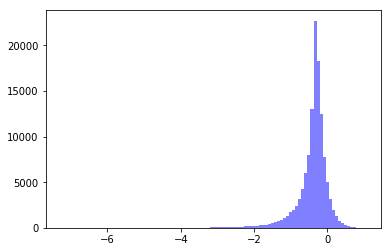

In [119]:
# predicted value distribution
%matplotlib inline  

import matplotlib.pyplot as plt
num_bins = 100
n, bins, patches = plt.hist(lgb_preds, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [122]:
# ranking all feature by avg importance score from Kfold, select top 100
all_features = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
all_features.reset_index(inplace=True)
important_features = list(all_features[0:100]['feature'])
all_features[0:100]

,feature,importance
0,hist_authorized_flag_mean,2040.4
1,hist_category_1_sum,1926.7
2,hist_month_lag_<lambda>,1749.6
3,hist_purchase_amount_min,1737.6
4,hist_category_1_mean,1632.1
5,hist_purchase_amount_mean,1608.4
6,hist_category_3_mean,1551.7
7,hist_purchase_amount_std,1517.3
8,hist_purchase_amount_max,1480.3
9,hist_merchant_id_nunique,1455.1


In [124]:
# Check feature correlation 
# important_features = list(final_importance['feature'][0:60])
df = train_final[important_features]
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
high_cor = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(high_cor))
print(high_cor)

15
['hist_purchase_amount_std', 'hist_purchase_amount_max', 'hist_purchase_amount_sum', 'hist_transactions_count', 'merch_avg_purchases_lag3_sum', 'merch_avg_purchases_lag6_sum', 'merch_avg_sales_lag6_mean', 'merch_avg_purchases_lag12_mean', 'merch_avg_sales_lag3_mean', 'merch_avg_purchases_lag3_mean', 'merch_avg_sales_lag12_mean', 'merch_numerical_2_sum', 'merch_avg_purchases_lag6_mean', 'merch_numerical_1_mean', 'merch_numerical_2_mean']


In [125]:
# final selected features: drop highly correlated features from important features.
features = [i for i in important_features if i not in high_cor]
print(len(features))
print(features)

36
['hist_authorized_flag_mean', 'hist_category_1_sum', 'hist_month_lag_<lambda>', 'hist_purchase_amount_min', 'hist_category_1_mean', 'hist_purchase_amount_mean', 'hist_category_3_mean', 'hist_merchant_id_nunique', 'month', 'hist_category_3_sum', 'hist_category_2_sum', 'hist_authorized_flag_sum', 'hist_installments_sum', 'hist_installments_std', 'hist_installments_mean', 'hist_merchant_category_id_nunique', 'hist_city_id_<lambda>', 'hist_merchant_category_id_<lambda>', 'hist_subsector_id_<lambda>', 'hist_category_2_mean', 'hist_subsector_id_nunique', 'merch_avg_sales_lag3_sum', 'hist_state_id_<lambda>', 'merch_avg_purchases_lag12_sum', 'hist_city_id_nunique', 'merch_avg_sales_lag12_sum', 'hist_installments_max', 'merch_numerical_1_sum', 'hist_installments_min', 'feature_1', 'hist_state_id_nunique', 'feature_2', 'feature_3', 'hist_authorized_flag_<lambda>', 'hist_category_1_<lambda>', 'merch_merchant_count']


In [126]:
# params for 2nd round training
params = {'boosting': 'gbdt',
          'objective':'regression',
          'metric': 'rmse',
          'learning_rate': 0.003, # 0.003! #0.005 #0.006 
          'num_leaves': 110, #110 #100 #150 large, but over-fitting
          'max_bin': 66,  #60 #50 # large,but slower,over-fitting
          'max_depth': 10, # deal with over-fitting
          'min_data_in_leaf': 30, # deal with over-fitting
          'min_child_samples': 20,
          'feature_fraction': 0.8,#0.5 #0.6 #0.8
          'bagging_fraction': 0.8,
          'bagging_freq': 40,#5  
          'bagging_seed': 11,
          'lambda_l1': 2,#1.3! #5 #1.2 #1
          'lambda_l2': 0.1 #0.1
         }

In [128]:
train = train_final[features]
test = test_final[features]

In [129]:
# Use Kfold predict
nfolds = 5
nrepeats = 2 

folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)
fold_pred = np.zeros(len(train))
lgb_preds = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)): #target.values
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx]) #categorical_feature=categorical_feats

    iteration = 3000
    lgb_model = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    fold_pred[val_idx] = lgb_model.predict(train.iloc[val_idx], num_iteration=lgb_model.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train.columns
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    lgb_preds += lgb_model.predict(test, num_iteration=lgb_model.best_iteration) / (nfolds*nrepeats)

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred, target))))

fold n°0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.82105	valid_1's rmse: 3.84813
[200]	training's rmse: 3.79758	valid_1's rmse: 3.84216
[300]	training's rmse: 3.77681	valid_1's rmse: 3.83783
[400]	training's rmse: 3.75827	valid_1's rmse: 3.83446
[500]	training's rmse: 3.74157	valid_1's rmse: 3.83276
[600]	training's rmse: 3.7266	valid_1's rmse: 3.83162
[700]	training's rmse: 3.71354	valid_1's rmse: 3.83033
[800]	training's rmse: 3.70261	valid_1's rmse: 3.82961
[900]	training's rmse: 3.69077	valid_1's rmse: 3.82875
[1000]	training's rmse: 3.68035	valid_1's rmse: 3.82869
Early stopping, best iteration is:
[970]	training's rmse: 3.68304	valid_1's rmse: 3.82865
fold n°1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.82871	valid_1's rmse: 3.81775
[200]	training's rmse: 3.80526	valid_1's rmse: 3.81113
[300]	training's rmse: 3.78557	valid_1's rmse: 3.8065
[400]	training's rmse: 3.76788	valid_1's rmse: 3.803

In [131]:
# feature importance
final_importance = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
final_importance.reset_index(inplace=True)
final_importance[0:50]

,feature,importance
0,hist_authorized_flag_mean,7209.6
1,hist_month_lag_<lambda>,6690.9
2,hist_purchase_amount_mean,6454.0
3,hist_category_1_sum,5853.3
4,month,5593.8
5,hist_purchase_amount_min,5310.4
6,hist_category_1_mean,4640.4
7,hist_authorized_flag_sum,4495.3
8,hist_category_3_mean,4451.9
9,hist_merchant_id_nunique,4213.2


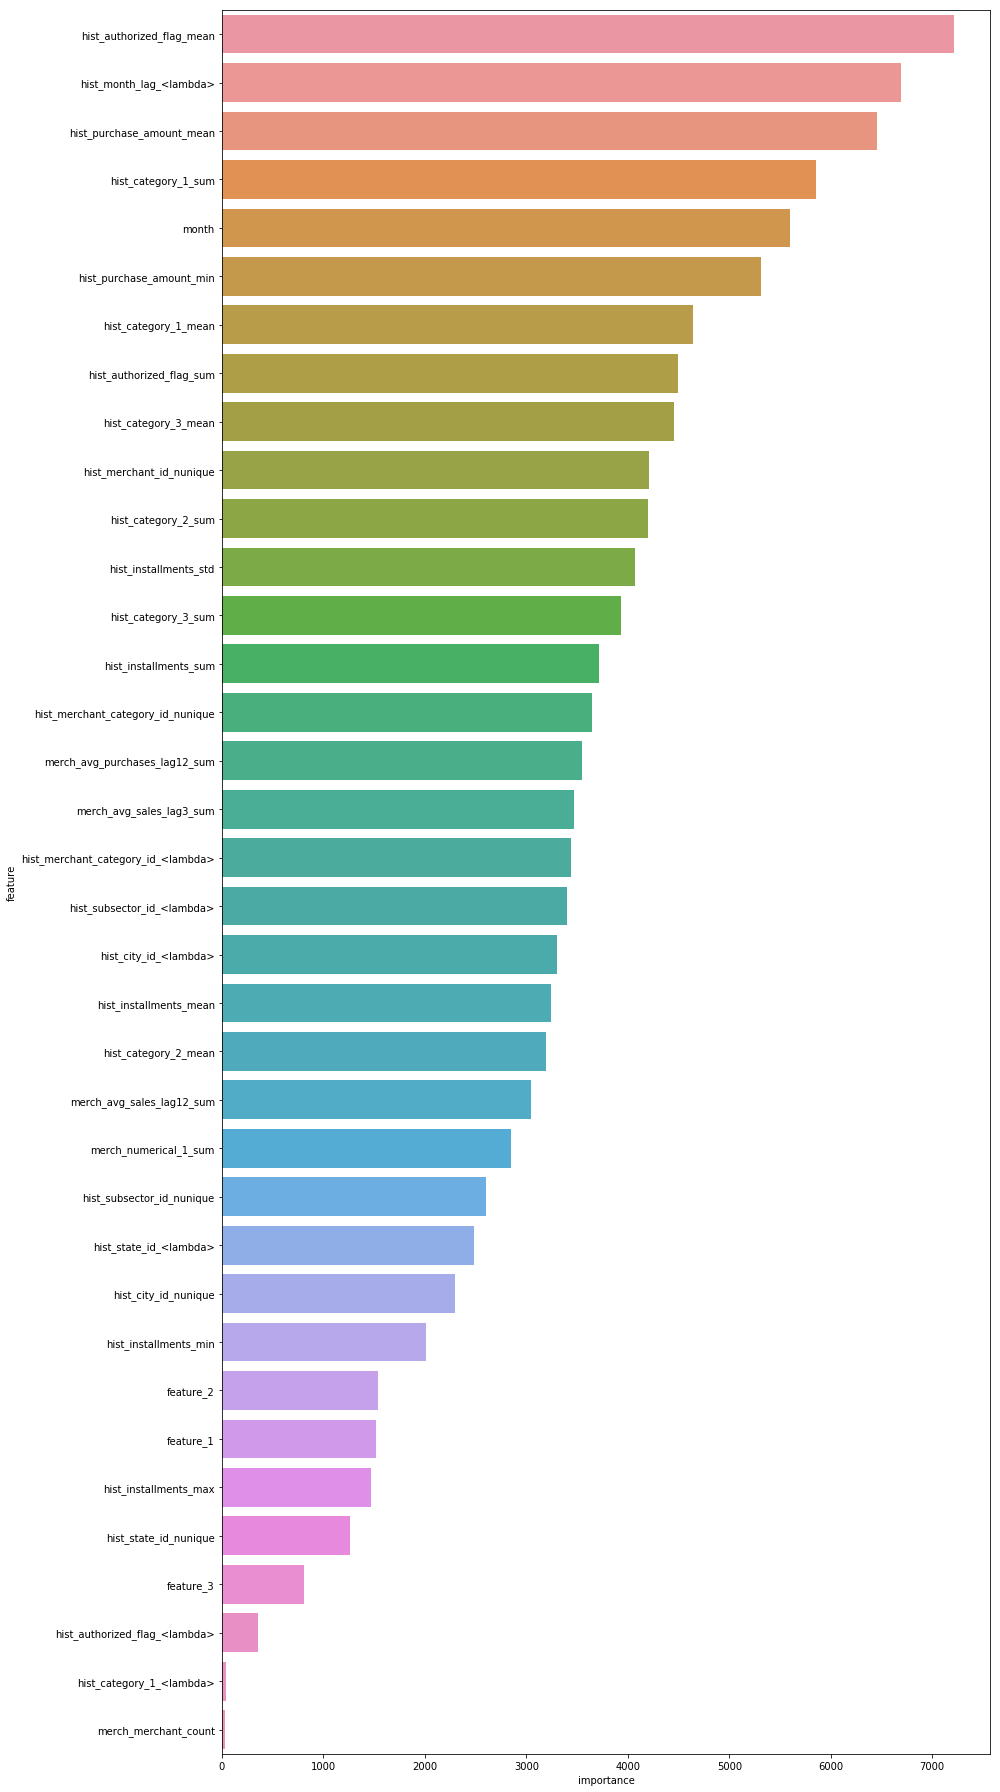

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,25))
sns.barplot(x="importance",y="feature",data=final_importance)
plt.tight_layout()
plt.savefig('lgbm_importances_2_merchants.png')

In [134]:
submission_df = pd.DataFrame()
submission_df['card_id'] = test_card_ids
submission_df["target"] = lgb_preds

In [135]:
submission_df.to_csv("submission.csv", index=None)